In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Set plot style for consistency
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Load the cleaned dataset
try:
    df = pd.read_csv("Prices_Cleaned.csv")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    print("Dataset loaded successfully!")
    print("Dataset shape:", df.shape)
except FileNotFoundError:
    print("Error: 'Prices_Cleaned.csv' file not found. Please ensure the file is in the correct directory.")
    exit()
except ValueError as e:
    print(f"Error in data parsing: {e}")
    exit()

Dataset loaded successfully!
Dataset shape: (851264, 10)


In [3]:
# Sort by date and reset index
df = df.sort_values(by="date").reset_index(drop=True)

In [4]:
# Validate date continuity and frequency
print("\nDate Range and Frequency:")
print(f"From: {df['date'].min()} To: {df['date'].max()}")
counts_per_day = df.groupby("date").size()
print(f"Unique dates: {len(counts_per_day)}")
print(f"Min observations per day: {counts_per_day.min()}, Max observations per day: {counts_per_day.max()}")
if(counts_per_day > 1).any():
    print("Warning: Multiple observations per day detected. Aggregating to daily mean.")
    df = df.groupby("date").mean(numeric_only=True).reset_index()
    df["date"] = pd.to_datetime(df["date"])


Date Range and Frequency:
From: 2010-01-04 00:00:00 To: 2016-12-30 00:00:00
Unique dates: 1762
Min observations per day: 467, Max observations per day: 501


In [5]:
# Check for missing dates in the time series
date_range = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")
missing_dates = date_range[~date_range.isin(df["date"])]
if len(missing_dates) > 0:
    print(f"Warning: {len(missing_dates)} missing dates detected in the time series.")
    print("Consider imputing missing dates if needed for time series analysis.")

Consider imputing missing dates if needed for time series analysis.


In [6]:
# Extract date-based features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek
df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)

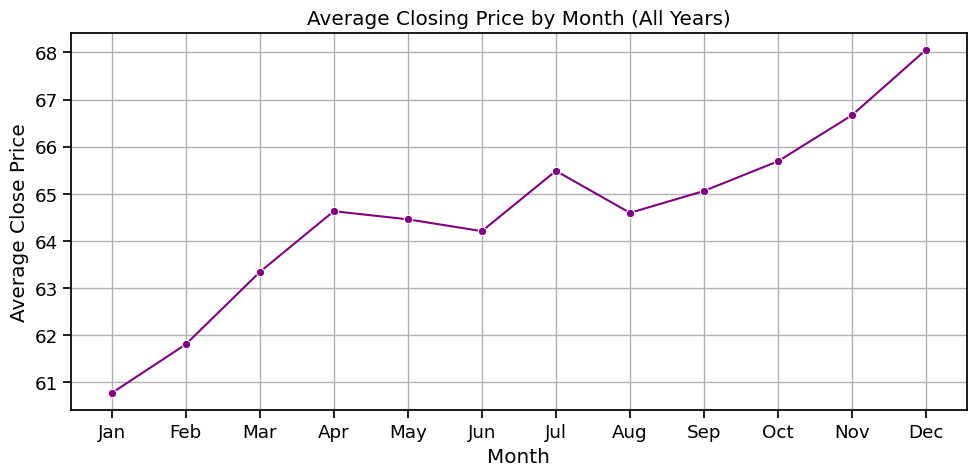

In [7]:
# Visualize average closing price by month
monthly_avg_close = df.groupby("month")["close"].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_avg_close.index, y=monthly_avg_close.values, marker="o", color="purple")
plt.title("Average Closing Price by Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Average Close Price")
plt.grid(True)
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                      "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.tight_layout()
plt.show()

In [8]:
# Calculate rolling statistics
df = df.sort_values("date")
df["rolling_mean_7"] = df["close"].rolling(window=7, min_periods=1).mean()
df["rolling_std_7"] = df["close"].rolling(window=7, min_periods=1).std()
df["rolling_mean_14"] = df["close"].rolling(window=14, min_periods=1).mean()
df["rolling_std_14"] = df["close"].rolling(window=14, min_periods=1).std()
df["rolling_mean_30"] = df["close"].rolling(window=30, min_periods=1).mean()
df["rolling_std_30"] = df["close"].rolling(window=30, min_periods=1).std()

# Additional feature: Volatility (std of daily returns)
df["daily_return"] = df["close"].pct_change()
df["volatility_7"] = df["daily_return"].rolling(window=7, min_periods=1).std()
df["volatility_30"] = df["daily_return"].rolling(window=30, min_periods=1).std()

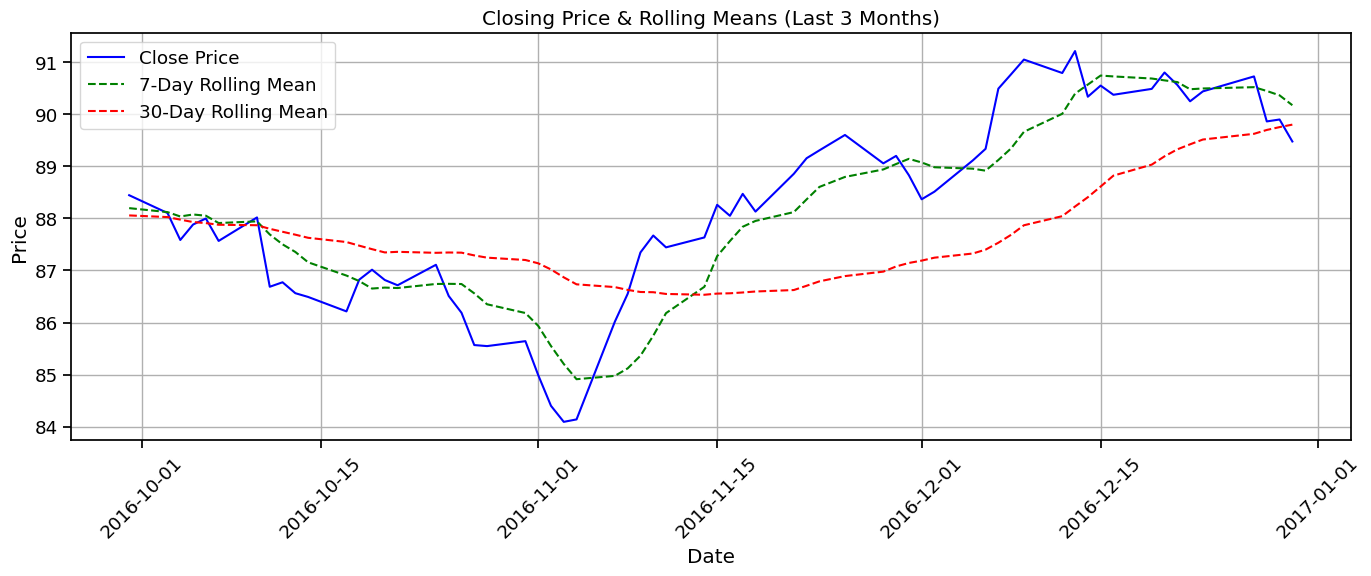

In [9]:
# Plot rolling mean vs actual close price for last 3 months
recent = df[df["date"] >= df["date"].max() - pd.DateOffset(months=3)]
plt.figure(figsize=(14, 6))
plt.plot(recent["date"], recent["close"], label="Close Price", color="blue")
plt.plot(recent["date"], recent["rolling_mean_7"], label="7-Day Rolling Mean", linestyle="--", color="green")
plt.plot(recent["date"], recent["rolling_mean_30"], label="30-Day Rolling Mean", linestyle="--", color="red")
plt.title("Closing Price & Rolling Means (Last 3 Months)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

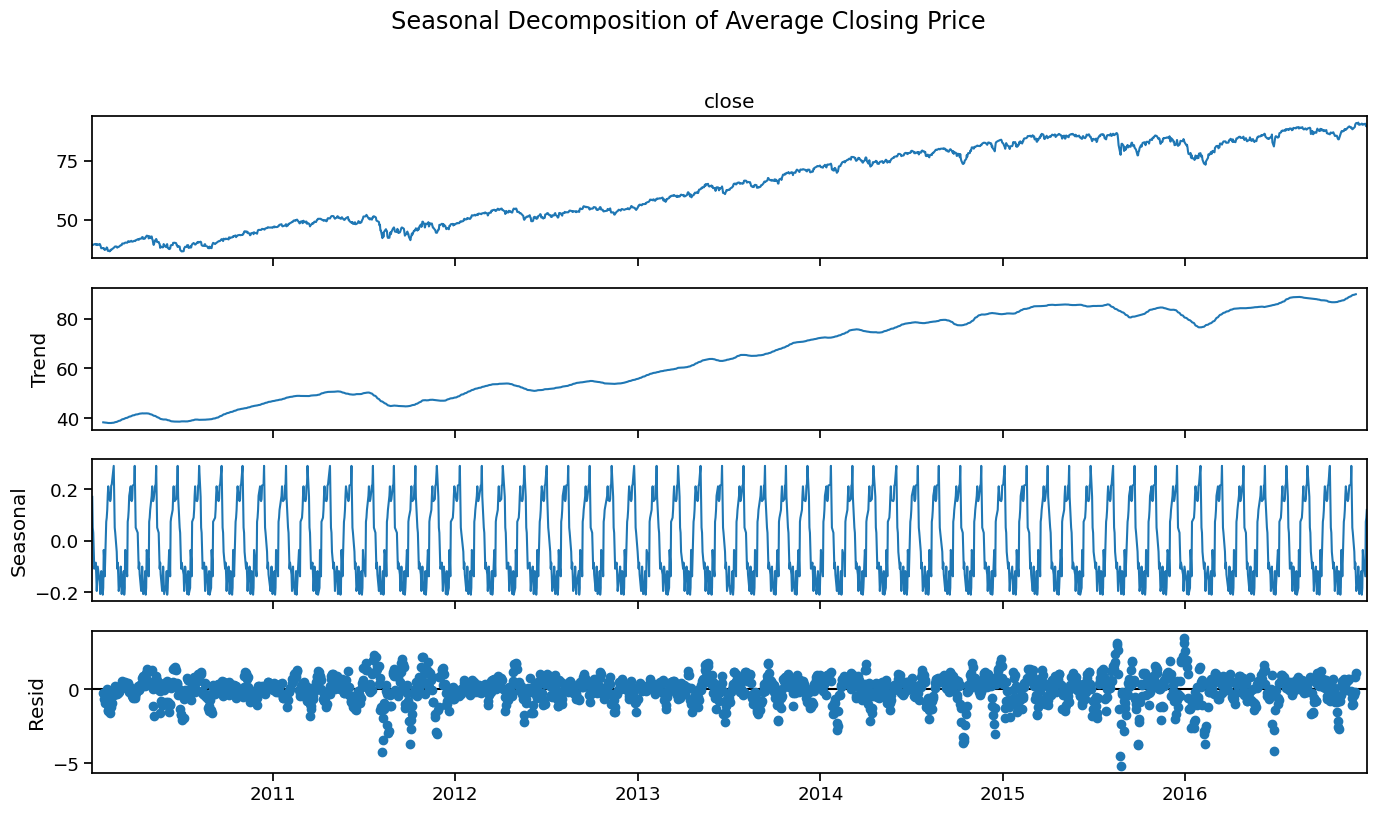

In [10]:
# Aggregate close price by date for time series analysis
ts_close = df.groupby("date")["close"].mean()

# Seasonal decomposition
try:
    decomposition = seasonal_decompose(ts_close, model='additive', period=30)  # Approx monthly seasonality
    fig = decomposition.plot()
    fig.set_size_inches(14, 8)
    plt.suptitle("Seasonal Decomposition of Average Closing Price", y=1.02)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Error in seasonal decomposition: {e}")

In [11]:
# Stationarity check using Augmented Dickey-Fuller test
adf_result = adfuller(ts_close.dropna())
print("\nStationarity Test (Augmented Dickey-Fuller):")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Null Hypothesis: Series is non-stationary")
if adf_result[1] < 0.05:
    print("Result: Stationary (reject null hypothesis)")
else:
    print("Result: Non-stationary (fail to reject null hypothesis)")

# Create lag features (previous day close prices, lags 1 to 7)
for lag in range(1, 8):
    df[f"lag_{lag}"] = df["close"].shift(lag)


Stationarity Test (Augmented Dickey-Fuller):
ADF Statistic: -0.8034
p-value: 0.8181
Null Hypothesis: Series is non-stationary
Result: Non-stationary (fail to reject null hypothesis)



Shape after lag feature creation: (1755, 29)


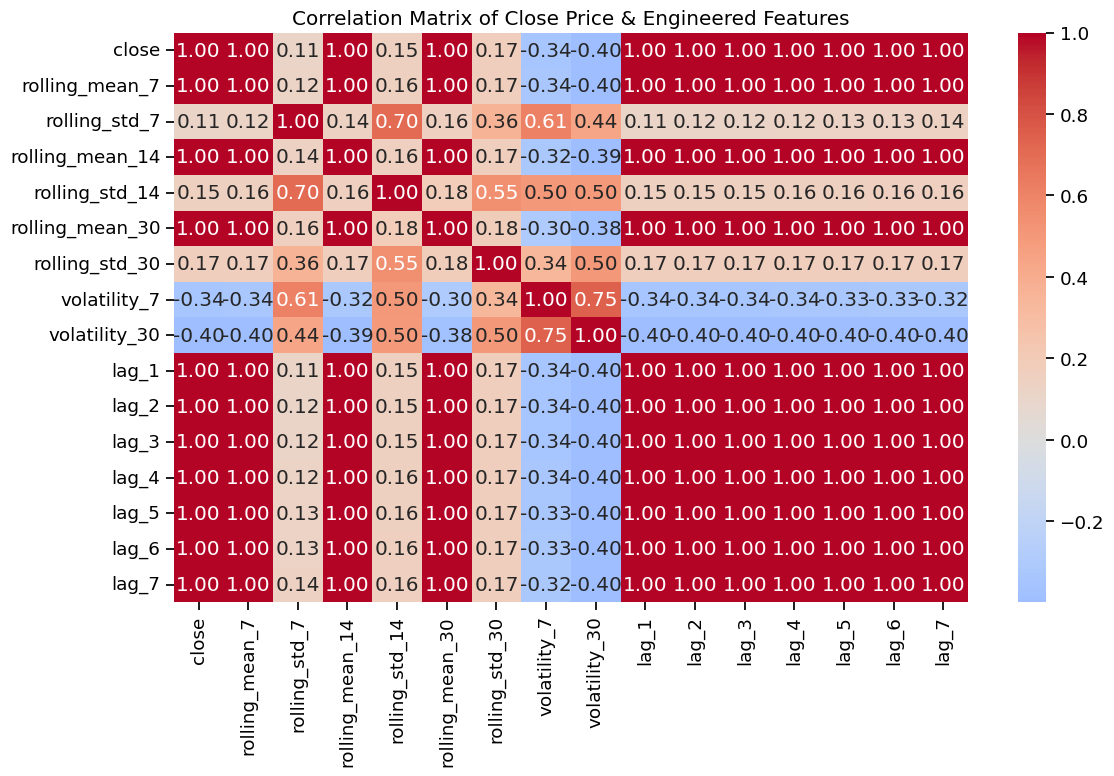

In [12]:
# Drop rows with NaNs from lagging
df_lagged = df.dropna().reset_index(drop=True)
print(f"\nShape after lag feature creation: {df_lagged.shape}")

# Correlation matrix for engineered features
corr_cols37 = ["close", "rolling_mean_7", "rolling_std_7", "rolling_mean_14", "rolling_std_14",
               "rolling_mean_30", "rolling_std_30", "volatility_7", "volatility_30"] + \
              [f"lag_{i}" for i in range(1, 8)]
plt.figure(figsize=(12, 8))
sns.heatmap(df_lagged[corr_cols37].corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix of Close Price & Engineered Features")
plt.tight_layout()
plt.show()

In [13]:
# # Save the prepared dataset
# df_lagged.to_csv("Prices_Prepared.csv", index=False)
# print("Prepared dataset saved to 'Prices_Prepared.csv'.")